## Comparing topic models

In this notebook, we sense check our BERTopic model by comparing it with that of LDA and Top2Vec. 

BERTopic is by considerable margins the most complicated technique of all three of these models due to its sentence transformer embeddings; but that is not to say it is best. BERTopic is also the most time-consuming framework to implement, and if we were to see diminishing returns, then we might instead wish to opt for a simpler model.

### LDA (Latent Dirichlet Allocation)

LDA remains exceedingly popular in academia. This is likely mostly due to how established it is as a topic modelling technique. But its 'cheap and cheerful' implementation can also provide a core advantage where the goal is to find a quick and straightforward representation of text. 

LDA assumes that documents are composed of words that can determine the topic. It is therefore semantically blind, due to its concern with word pattern co-occurances. As such, LDA will not attempt to create topics composed of semantically similar words or phrases. In LDA, we must also pre-specify the number of topics to analyse.

### Preprocessing

Unlike BERTopic, LDA demands that we heavily preprocess our data, tokenising, lemmatizing and removing stop words.

In [3]:
import pandas as pd

data = pd.read_csv('../Data/processed_paragraphs.csv')
text = data['ProcessedParagraph']
text

0       Pre-amble They were a 52-year-old male with no...
1       On a date, they contacted the CRISIS Home Reso...
2       Multi-Disciplinary Team (“MDT”) Meetings I am ...
3       Risk assessments At the initial triage (undert...
4       Discharge They were discharged from the care o...
                              ...                        
1243    It is known that a prisoner's risk of self-har...
1244    The PPO report recommended that an ACCT should...
1245    The healthcare screening, which is a question-...
1246    Some prisoners at HMP Peterborough are allowed...
1247    In addition, the deceased referred to experime...
Name: ProcessedParagraph, Length: 1248, dtype: object

In [5]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import pandas as pd

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Define stop words
stop_words = set(stopwords.words('english'))

# Define a function for lowercasing, removing special characters, and removing numbers
def preprocess_text(text):
    return ''.join(char.lower() if char.isalpha() or char.isspace() else ' ' for char in text)

# Define a function for tokenizing text
def tokenize(text):
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha()]
    return [word for word in words if word not in stop_words]

# Define a function to remove stop words
def remove_stopwords(text):
    words = text.split()
    return ' '.join(word for word in words if word not in stop_words)

# Apply text preprocessing to the content
processed_text = text.apply(preprocess_text)

# Remove stop words from the preprocessed content
processed_text = processed_text.apply(remove_stopwords)

# Apply word tokenization and pre-processing to the content
processed_text = processed_text.apply(tokenize)


## Lemmatize the text

from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, download
from nltk.corpus import wordnet

# Download NLTK data
download('averaged_perceptron_tagger')
download('wordnet')

# Map POS tags for lemmatization
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Initialise the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize tokens
def lemmatize_tokens(tokens):
    try:
        # POS tagging
        pos_tags = pos_tag(tokens)
        # Lemmatize with POS tags
        return [lemmatizer.lemmatize(token, get_wordnet_pos(tag) or wordnet.NOUN) for token, tag in pos_tags]
    except Exception as e:
        print(f"Error processing content: {e}")
        return []


# Apply lemmatization to the preprocessed content
processed_text = processed_text.apply(lemmatize_tokens)


processed_text


[nltk_data] Downloading package punkt to /home/sam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sam/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/sam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0       [pre, amble, year, old, male, history, mental,...
1       [date, contact, crisis, home, resolution, trea...
2       [multi, disciplinary, team, mdt, meeting, conc...
3       [risk, assessment, initial, triage, undertaken...
4       [discharge, discharge, care, lpt, plan, suppor...
                              ...                        
1243    [know, prisoner, risk, self, harm, suicide, ma...
1244    [ppo, report, recommend, acct, open, whenever,...
1245    [healthcare, screen, question, answer, discuss...
1246    [prisoner, hmp, peterborough, allow, carry, ce...
1247    [addition, decease, referred, experimentation,...
Name: ProcessedParagraph, Length: 1248, dtype: object

Next, we need to make a document-term matrix. This is created by counting the occurrence of every term in each piece of text and then normalising the counts to create a matrix of values.

In [9]:
### Create document-term matrix
from gensim import corpora

# Creating document-term matrix 
dictionary = corpora.Dictionary(processed_text)

doc_term_matrix = [dictionary.doc2bow(doc) for doc in processed_text]

# Print first 30 matrix entries
print(doc_term_matrix[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 3), (22, 1), (23, 2), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1)]


Since LDA cannot ascertain the ideal number of topics itself, we must provide a 'number of topics parameter'. 

We can do this through testing for 'perplexity'. Perplexity measures the ability of our model to predict the next word in unseen or held-out documents. A lower perplexity score indicates better model performance.

Number of topics: 2, Perplexity: -7.207142216859145
Number of topics: 22, Perplexity: -7.945009634622128
Number of topics: 42, Perplexity: -8.539157043259504
Number of topics: 62, Perplexity: -9.027604773293936
Number of topics: 82, Perplexity: -9.494957582270368
Number of topics: 102, Perplexity: -9.795971945924432
Number of topics: 122, Perplexity: -10.173976383835775
Number of topics: 142, Perplexity: -10.536502653497168
Number of topics: 162, Perplexity: -10.824782847689283
Number of topics: 182, Perplexity: -11.210767463874054
Number of topics: 202, Perplexity: -11.478243240679483
Number of topics: 2, Perplexity: -7.207142216859145
Number of topics: 22, Perplexity: -7.945009634622128
Number of topics: 42, Perplexity: -8.539157043259504
Number of topics: 62, Perplexity: -9.027604773293936
Number of topics: 82, Perplexity: -9.494957582270368
Number of topics: 102, Perplexity: -9.795971945924432
Number of topics: 122, Perplexity: -10.173976383835775
Number of topics: 142, Perplexity:

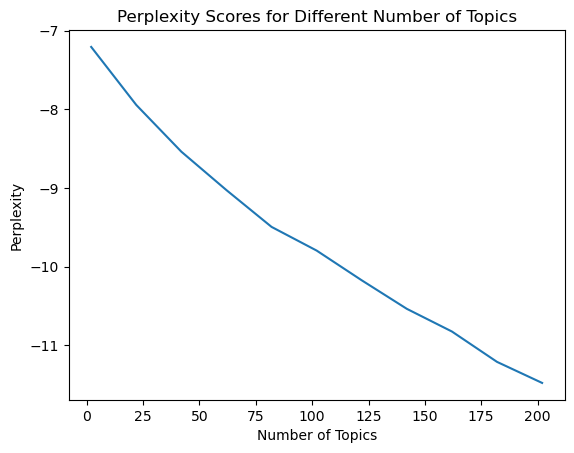

In [21]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# Function to calculate perplexity for different numbers of topics
def compute_perplexity(dictionary, doc_term_matrix, texts, start, limit, step):
    perplexity_values = []
    for num_topics in range(start, limit, step):
        lda_model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary, random_state=100)
        perplexity = lda_model.log_perplexity(doc_term_matrix)
        perplexity_values.append((num_topics, perplexity))
        print(f'Number of topics: {num_topics}, Perplexity: {perplexity}')
    return perplexity_values

# Calculate perplexity for different numbers of topics
start = 2  # minimum number of topics
limit = 203  # maximum number of topics
step = 20  # step size to vary the number of topics

perplexity_values = compute_perplexity(dictionary, doc_term_matrix, processed_text, start, limit, step)

# Print the perplexity scores
for num_topics, perplexity in perplexity_values:
    print(f'Number of topics: {num_topics}, Perplexity: {perplexity}')

## Plot it!
import matplotlib.pyplot as plt

x = [num_topics for num_topics, perplexity in perplexity_values]
y = [perplexity for num_topics, perplexity in perplexity_values]

plt.plot(x, y)
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.title("Perplexity Scores for Different Number of Topics")
plt.show()



Number of topics: 2, Coherence: 0.32461024566826047
Number of topics: 22, Coherence: 0.3517035132209032
Number of topics: 42, Coherence: 0.3242452688111365
Number of topics: 62, Coherence: 0.31439158215219365
Number of topics: 82, Coherence: 0.32711556246005347
Number of topics: 102, Coherence: 0.31742587528733024
Number of topics: 122, Coherence: 0.3125572036490713
Number of topics: 142, Coherence: 0.307912880573399
Number of topics: 162, Coherence: 0.3180892857713047
Number of topics: 182, Coherence: 0.31213404617275614
Number of topics: 202, Coherence: 0.3067992023475855


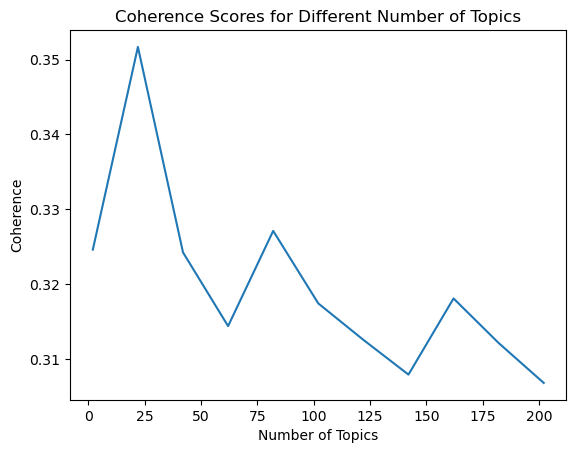

In [31]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence(dictionary, doc_term_matrix, texts, start, limit, step):
    coherence_values = []
    for num_topics in range(start, limit, step):
        lda_model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary, random_state=100)
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence = coherence_model.get_coherence()
        coherence_values.append((num_topics, coherence))
        print(f'Number of topics: {num_topics}, Coherence: {coherence}')
    return coherence_values

# Calculate coherence for different numbers of topics
coherence_values = compute_coherence(dictionary, doc_term_matrix, processed_text, start, limit, step)

# Plot coherence scores
x = [num_topics for num_topics, coherence in coherence_values]
y = [coherence for num_topics, coherence in coherence_values]

plt.plot(x, y)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
plt.title("Coherence Scores for Different Number of Topics")
plt.show()


The graphs aren't great. Our perplexity score continues to decrease almost linearly, with no sign of any diminishing returns. This could suggest that our reports are far too heterogeneous to model within a restrictive number of topics, under LDA assumptions.

The coherence scores generally get worse as the number of topics increases, though it seems to settle on 25 topics as the optimal value.